In [16]:
import argparse
import os
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np

#os.chdir('D:/GANart/GAN-Artwork-Generation')

In [17]:
from parameters import *
from model_cGAN import *
from dataloader import *

In [18]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Create the dataloader
dataloader = get_dataset()

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

Random Seed:  999
cuda:0


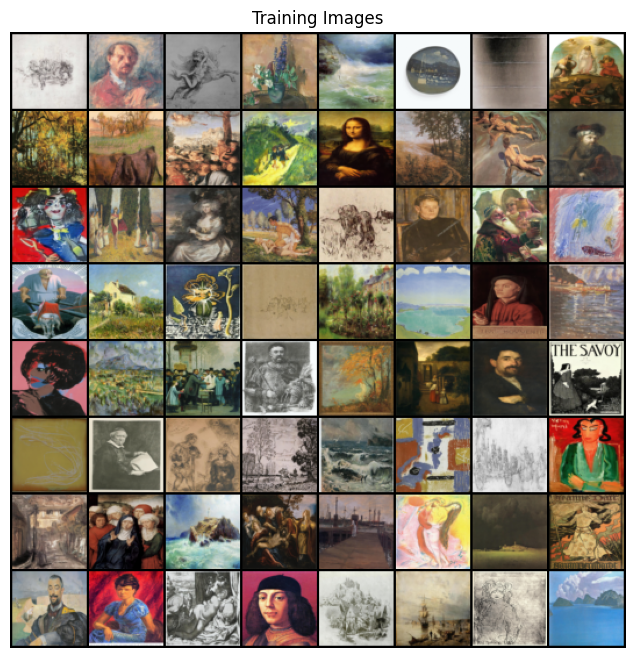

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [20]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (label_emb): Embedding(27, 27)
  (main): Sequential(
    (0): ConvTranspose2d(177, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

In [21]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (label_emb): Embedding(27, 2048)
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1

In [22]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
example_size = 4
fixed_noise = torch.randn(n_class*example_size, nz, 1, 1, device=device)
fixed_label = torch.tensor(list(np.repeat([i for i in range(n_class)], example_size))).type(torch.LongTensor).to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
from torchvision.utils import save_image
img_save_path = 'images'
#os.makedirs("images", exist_ok=True)
os.makedirs(img_save_path, exist_ok=True)

In [24]:
# Checkpoint kontrolü
import glob

checkpoint_path = 'checkpoints'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

start_epoch = 0

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

checkpoints = glob.glob('checkpoints/*.pth')
if checkpoints:
    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    if os.path.exists(latest_checkpoint):
        checkpoint = torch.load(latest_checkpoint)
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netD.load_state_dict(checkpoint['netD_state_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        G_losses = checkpoint['G_losses']
        D_losses = checkpoint['D_losses']
        print(f"Checkpoint'ten devam ediliyor, {start_epoch} epoch'tan başlanıyor.")
else: print("Checkpoint bulunamadı sıfırdan başlatılıyor")

Checkpoint'ten devam ediliyor, 201 epoch'tan başlanıyor.


In [10]:
# Training Loop

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, num_epochs):
    # For each batch in the dataloader
    for i, (data, real_style_labels) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # style labels - iso
        real_style_labels = real_style_labels.to(device)
        fake_style_labels = torch.tensor(np.random.choice(n_class, size = b_size)).type(torch.LongTensor).to(device)
        # Forward pass real batch through D
        output = netD(gaussian(real_cpu, mean=0, stddev=0.5*0.01**(epoch/num_epochs)), real_style_labels).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise, fake_style_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), fake_style_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, fake_style_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if 1 == 1:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        if i % 300 == 0:
            save_image(fake, f'./images/fake_samples_epoch_{epoch:03d}_iter_{i:03d}.png', normalize=True)
            img_list.append(vutils.make_grid(fake, nrow = example_size,padding=2, normalize=True))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save checkpoint
        if epoch % 5 == 0 and i == len(dataloader) - 1:
            torch.save({
                'epoch': epoch,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'G_losses': G_losses,
                'D_losses': D_losses,
            }, os.path.join(checkpoint_path, f'checkpoint-{epoch}.pth'))
            print(f"Checkpoint saved at epoch {epoch}.")


        iters += 1

Starting Training Loop...
[201/202][0/637]	Loss_D: 0.2106	Loss_G: 5.7978	D(x): 0.9984	D(G(z)): 0.0951 / 0.0524
[201/202][1/637]	Loss_D: 0.2591	Loss_G: 9.0783	D(x): 0.9682	D(G(z)): 0.0980 / 0.0054
[201/202][2/637]	Loss_D: 0.1934	Loss_G: 11.6397	D(x): 0.9999	D(G(z)): 0.0630 / 0.0032
[201/202][3/637]	Loss_D: 0.0747	Loss_G: 11.4472	D(x): 0.9984	D(G(z)): 0.0366 / 0.0024
[201/202][4/637]	Loss_D: 0.0038	Loss_G: 11.7054	D(x): 0.9997	D(G(z)): 0.0033 / 0.0008
[201/202][5/637]	Loss_D: 0.0190	Loss_G: 12.2296	D(x): 0.9870	D(G(z)): 0.0005 / 0.0003
[201/202][6/637]	Loss_D: 0.3952	Loss_G: 7.7525	D(x): 0.8179	D(G(z)): 0.0066 / 0.0227
[201/202][7/637]	Loss_D: 0.1622	Loss_G: 8.1602	D(x): 0.9998	D(G(z)): 0.0723 / 0.0054
[201/202][8/637]	Loss_D: 0.0832	Loss_G: 8.2152	D(x): 0.9720	D(G(z)): 0.0288 / 0.0072
[201/202][9/637]	Loss_D: 0.0976	Loss_G: 8.0421	D(x): 0.9945	D(G(z)): 0.0637 / 0.0035
[201/202][10/637]	Loss_D: 0.0475	Loss_G: 10.3160	D(x): 0.9997	D(G(z)): 0.0260 / 0.0010
[201/202][11/637]	Loss_D: 0.3649	

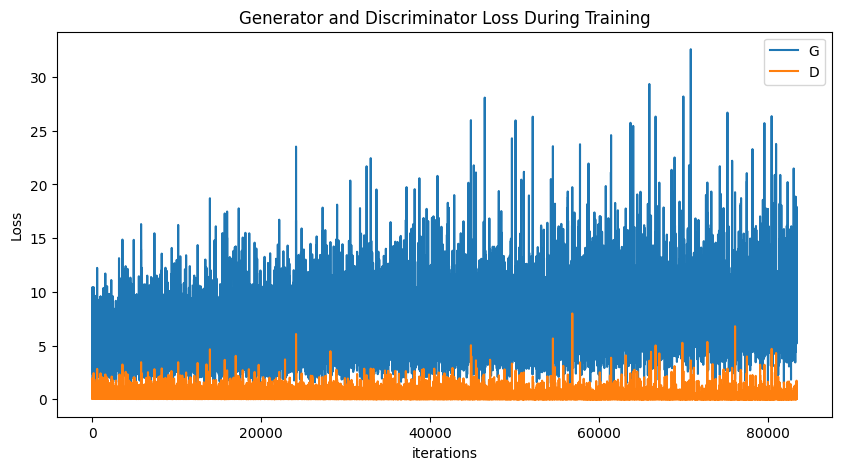

In [11]:
# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

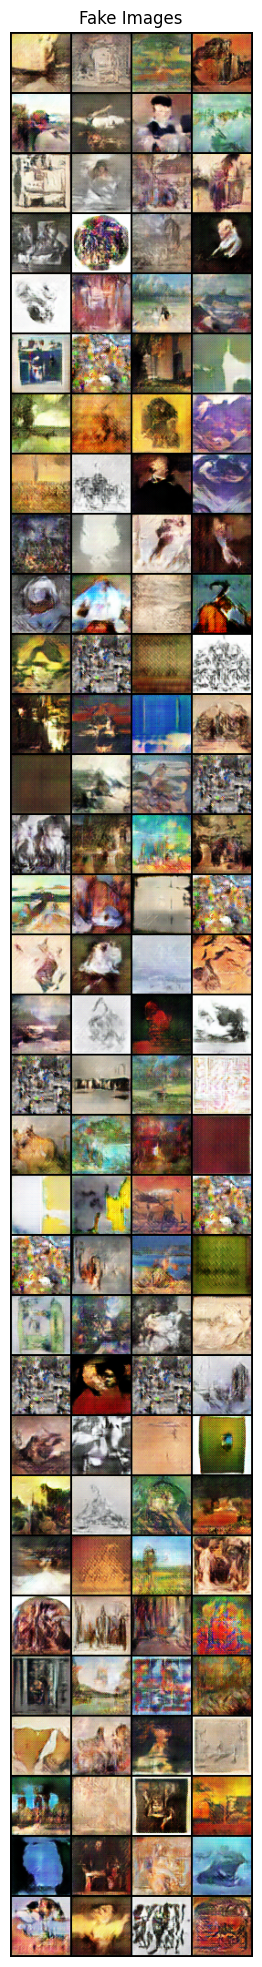

In [12]:
# Plot the fake images from the last epoch
plt.figure(figsize=(25,25))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()

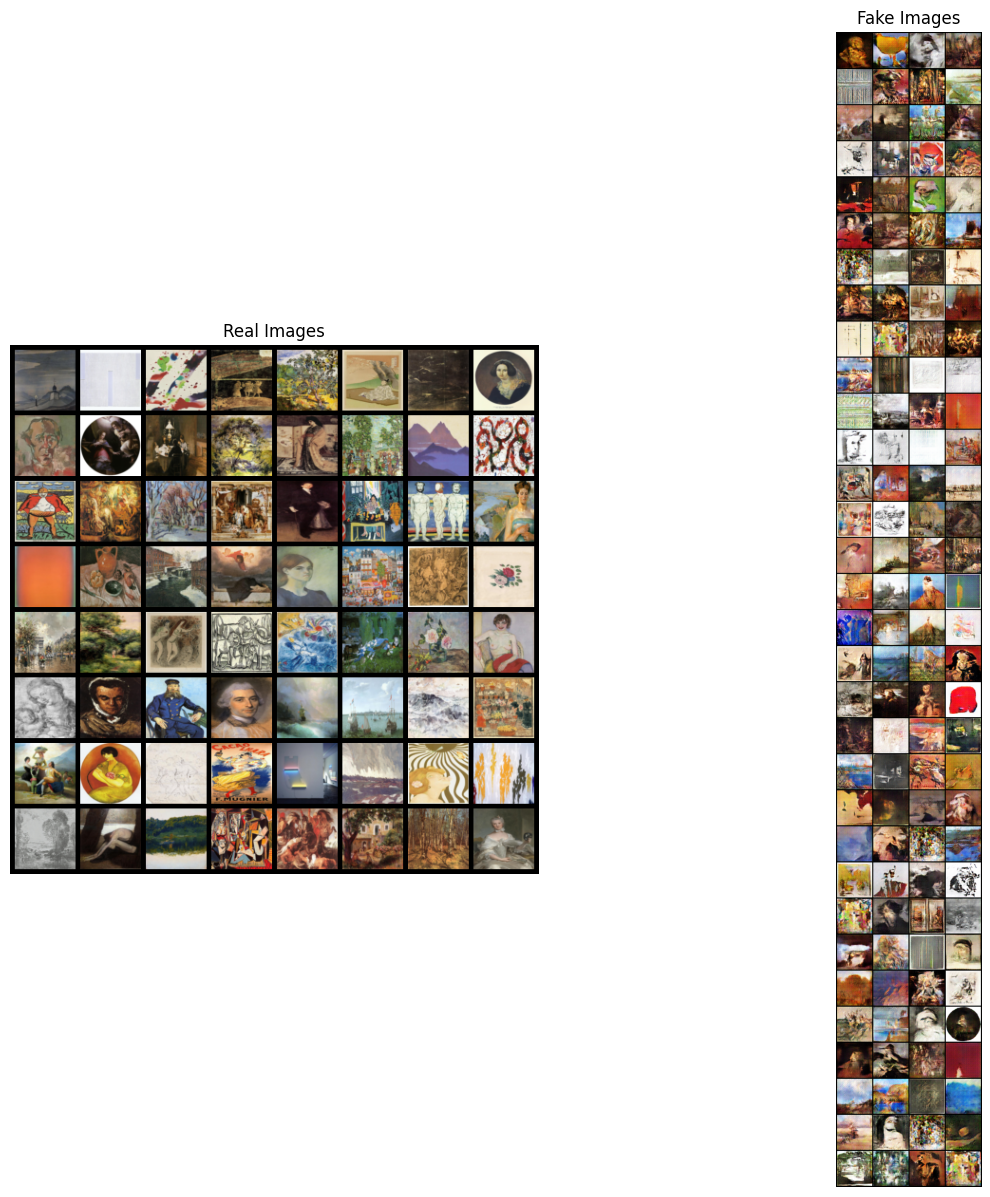

In [13]:
# Real vs Fake
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[1].to(device)[:64] ,padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Save models after training
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')